In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AML/archive/USvideos.csv")
df

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,BZt0qjTWNhw,18.14.06,The Cat Who Caught the Laser,AaronsAnimals,15,2018-05-18T13:00:04.000Z,"aarons animals|""aarons""|""animals""|""cat""|""cats""...",1685609,38160,1385,2657,https://i.ytimg.com/vi/BZt0qjTWNhw/default.jpg,False,False,False,The Cat Who Caught the Laser - Aaron's Animals
40945,1h7KV2sjUWY,18.14.06,True Facts : Ant Mutualism,zefrank1,22,2018-05-18T01:00:06.000Z,[none],1064798,60008,382,3936,https://i.ytimg.com/vi/1h7KV2sjUWY/default.jpg,False,False,False,NaN
40946,D6Oy4LfoqsU,18.14.06,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,24,2018-05-18T17:34:22.000Z,I gave safiya nygaard a perfect hair makeover ...,1066451,48068,1032,3992,https://i.ytimg.com/vi/D6Oy4LfoqsU/default.jpg,False,False,False,I had so much fun transforming Safiyas hair in...
40947,oV0zkMe1K8s,18.14.06,How Black Panther Should Have Ended,How It Should Have Ended,1,2018-05-17T17:00:04.000Z,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957,2846,13088,https://i.ytimg.com/vi/oV0zkMe1K8s/default.jpg,False,False,False,How Black Panther Should Have EndedWatch More ...


In [ ]:
df.dtypes

video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
dtype: object

### Data Cleaning: 
1. Convert trending_date and publish_time to datetime format
2. Convert trending date to day number of year, month, and year number 
3. Convert publish time to the hour of the day (year and date should be similar to trending date.
4. Calculate the number of days between the publish day and the trending_date

In [ ]:
#trending_date
df["trending_date"]=pd.to_datetime(df["trending_date"],format="%y.%d.%m")
df["trending_year"] = df['trending_date'].dt.year
df["trending_month"] = df['trending_date'].dt.month
df["trending_day_number"] = df['trending_date'].dt.dayofyear

In [ ]:
#publish_time
df['publish_time']=pd.to_datetime(pd.Series(df['publish_time'].apply(lambda x:x[:19])))
df["publish_hour"] = df['publish_time'].dt.hour

In [ ]:
#difference between publish date and trending date
df["day_difference"] = (df["trending_date"]-df['publish_time']).dt.days
df

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,trending_year,trending_month,trending_day_number,publish_hour,day_difference
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,2017,11,318,17,0
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",2017,11,318,7,0
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,2017,11,318,19,1
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,2017,11,318,11,0
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,2017,11,318,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,BZt0qjTWNhw,2018-06-14,The Cat Who Caught the Laser,AaronsAnimals,15,2018-05-18 13:00:04,"aarons animals|""aarons""|""animals""|""cat""|""cats""...",1685609,38160,1385,2657,https://i.ytimg.com/vi/BZt0qjTWNhw/default.jpg,False,False,False,The Cat Who Caught the Laser - Aaron's Animals,2018,6,165,13,26
40945,1h7KV2sjUWY,2018-06-14,True Facts : Ant Mutualism,zefrank1,22,2018-05-18 01:00:06,[none],1064798,60008,382,3936,https://i.ytimg.com/vi/1h7KV2sjUWY/default.jpg,False,False,False,NaN,2018,6,165,1,26
40946,D6Oy4LfoqsU,2018-06-14,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,24,2018-05-18 17:34:22,I gave safiya nygaard a perfect hair makeover ...,1066451,48068,1032,3992,https://i.ytimg.com/vi/D6Oy4LfoqsU/default.jpg,False,False,False,I had so much fun transforming Safiyas hair in...,2018,6,165,17,26
40947,oV0zkMe1K8s,2018-06-14,How Black Panther Should Have Ended,How It Should Have Ended,1,2018-05-17 17:00:04,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957,2846,13088,https://i.ytimg.com/vi/oV0zkMe1K8s/default.jpg,False,False,False,How Black Panther Should Have EndedWatch More ...,2018,6,165,17,27


# Regression Models






# 1. Likes

  Features used: category_id, views, dislikes, comment_count, comments_disabled, ratings_disabled, video_error_or_removed, trending_year, trending_month, trending_day_number, publish_hour, day_difference

  Test & Dev Data Split: 80-20

  Model Selection: cv = 10, stratified Cross Validation

In [ ]:
target = df['likes']
features = ['category_id','views','dislikes','comment_count','comments_disabled','ratings_disabled','video_error_or_removed', 'trending_year', 'trending_month', 'trending_day_number', 'publish_hour','day_difference']
data_x = df[features]

Text(0.5, 1.0, 'Like Distrbution')

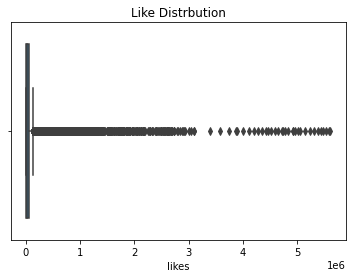

In [ ]:
# target distribution
fig = plt.figure()
ax = sns.boxplot(target)
ax.set_title("Like Distrbution")

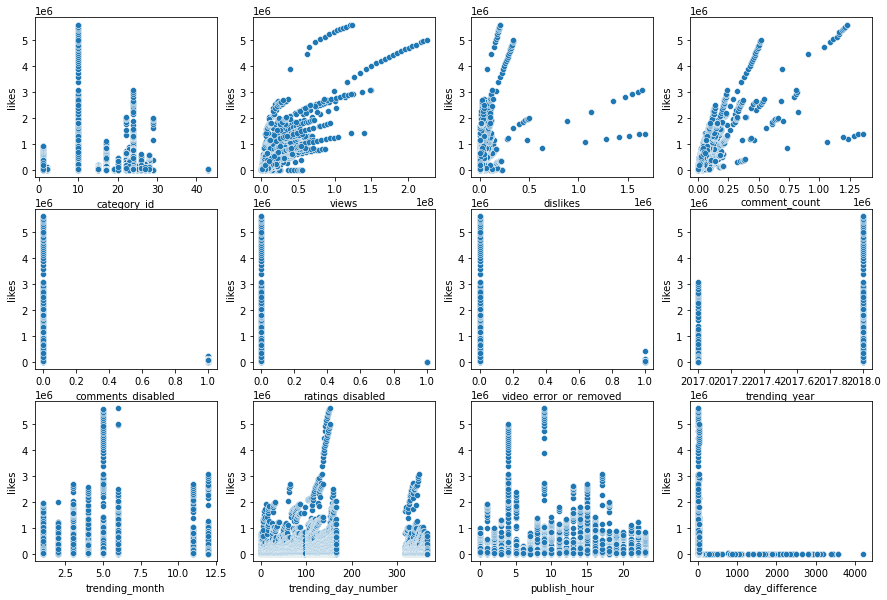

In [ ]:
fig,ax = plt.subplots(3, 4, figsize = (15,10))
for var,subplot in zip(features,ax.flatten()):
  sns.scatterplot(x=var, y=target, data=data_x, ax=subplot)

## Model1: Simple Linear Regression

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
dev_X, test_X, dev_y, test_y = train_test_split(data_x, target, test_size = 0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), features))

In [ ]:
pipe1 = make_pipeline(preprocess, LinearRegression())
scores = cross_val_score(pipe1, dev_X, dev_y, cv = 10, error_score='raise')
print(scores)
print(np.mean(scores))

[0.88804331 0.90562824 0.88043033 0.8652267  0.86104485 0.87272127
 0.89135513 0.88813528 0.89038975 0.9006685 ]
0.8843643355100419



## Model 2: Ridge Regression

#### Simple Model

In [ ]:
from sklearn.linear_model import Ridge
pipe2 = make_pipeline(preprocess, Ridge())
scores2 = cross_val_score(pipe2, dev_X, dev_y, cv = 10, error_score='raise')
print(scores2)
print(np.mean(scores2))

[0.88804292 0.90563158 0.88042772 0.86522219 0.86104017 0.87272983
 0.89135479 0.88813681 0.89038781 0.90067242]
0.8843646241132515


#### Hypterparameter Tuning

In [ ]:
pipe2_tuning = make_pipeline(preprocess, GridSearchCV(Ridge(), param_grid = [{"alpha":np.logspace(-3,3,10)}],return_train_score=True))
pipe2_tuning.fit(dev_X, dev_y)
grid_search_results2 = pipe2_tuning.named_steps["gridsearchcv"]
print(f"Best score:", grid_search_results2.best_score_)
print(f"Best alpha:", grid_search_results2.best_params_)
print(f"Test score:", pipe2_tuning.score(test_X, test_y))

Best score: 0.8854737085756247
Best alpha: {'alpha': 46.41588833612773}
Test score: 0.8805036209477195


## Model 3: Lasso Regression 

#### Simple Model

In [ ]:
from sklearn.linear_model import Lasso
pipe3 = make_pipeline(preprocess, Lasso(alpha=1))
scores3 = cross_val_score(pipe3, dev_X, dev_y, cv = 10, error_score='raise')
print(scores3)
print(np.mean(scores3))

[0.88804153 0.90562816 0.88042945 0.86522525 0.86104383 0.87272579
 0.89135578 0.88813517 0.89039049 0.90066884]
0.8843644281937106


#### Hyperparameter Tuning

In [ ]:
pipe3_tuning = make_pipeline(preprocess, GridSearchCV(Lasso(), param_grid = [{"alpha":np.logspace(-4,2,30)}], return_train_score=True))
pipe3_tuning.fit(dev_X, dev_y)
grid_search_results3 = pipe3_tuning.named_steps["gridsearchcv"]
print(f"Best score:", grid_search_results3.best_score_)
print(f"Best alpha:", grid_search_results3.best_params_)
print(f"Test score:", pipe3_tuning.score(test_X, test_y))

Best score: 0.8854749829467075
Best alpha: {'alpha': 38.56620421163472}
Test score: 0.8805183376677944


## Model 4: Elastic-net Regression

#### Simple Model

In [ ]:
from sklearn.linear_model import ElasticNet
pipe4 = make_pipeline(preprocess, ElasticNet(alpha=1))
scores4 = cross_val_score(pipe4, dev_X, dev_y, cv = 10, error_score='raise')
print(scores4)
print(np.mean(scores4))

[0.79742129 0.83518319 0.77720604 0.76476664 0.75581452 0.82356902
 0.79783912 0.81759372 0.81869994 0.83260343]
0.8020696907342746


### Hypterparameter Tuning

In [ ]:
pipe4_tuning = make_pipeline(preprocess, GridSearchCV(ElasticNet(), param_grid = [{"alpha":np.logspace(-4,2,20),"l1_ratio":np.logspace(-2,0,10)}], return_train_score=True))
pipe4_tuning.fit(dev_X, dev_y)
grid_search_results4 = pipe4_tuning.named_steps["gridsearchcv"]
print(f"Best score:", grid_search_results4.best_score_)
print(f"Best alpha:", grid_search_results4.best_params_)
print(f"Test score:", pipe4_tuning.score(test_X, test_y))

Best score: 0.8854743520935703
Best alpha: {'alpha': 48.32930238571752, 'l1_ratio': 1.0}
Test score: 0.8805186632034138


## Conclusion

All of the models above generated similiar results, however the model gets more complex. Thus, in this case, we will choose a simple and efficent regresion model -- Ridge Regression.

In [ ]:
pipe2_tuning.fit(dev_X, dev_y)
predicted_y = pipe2_tuning.predict(test_X)

Text(0, 0.5, 'residual')

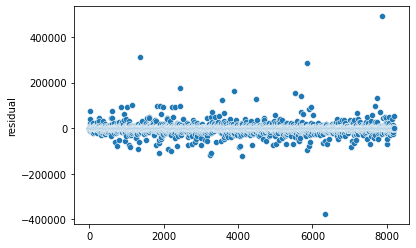

In [ ]:
ax = sns.scatterplot(np.arange(len(test_y)), (test_y - pipe2_tuning.predict(test_X)))
ax.set_ylabel("residual")

First 5 predictions of the test dataset

In [ ]:
print("Predicted likes:", predicted_y[:5],'\n', "Actual Likes:", test_y[:5].to_list())

Predicted likes: [31258.78065699 17871.55341397 30833.82512519 14456.59279408
 22488.56195352] 
 Actual Likes: [21951, 10070, 33670, 13878, 16873]


# 2. Comments:

Targeet:  comment_count

Features used: category_id, views, likes, dislikes, comments_disabled, ratings_disabled, video_error_or_removed, trending_year, trending_month, trending_day_number, publish_hour, day_difference

Test & Dev Data Split: 80-20

Model Selection: cv = 10, stratified Cross Validation

In [ ]:
target = df['comment_count']
features = ['category_id','views','likes','dislikes','comments_disabled','ratings_disabled','video_error_or_removed', 'trending_year', 'trending_month', 'trending_day_number', 'publish_hour','day_difference']
data_x = df[features]

Text(0.5, 1.0, 'Comment Count Distrbution')

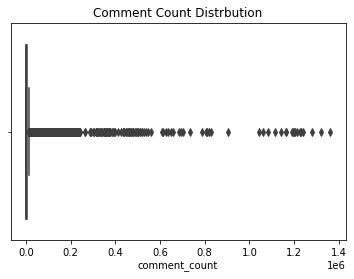

In [ ]:
# target distribution
fig = plt.figure()
ax = sns.boxplot(target)
ax.set_title("Comment Count Distrbution")

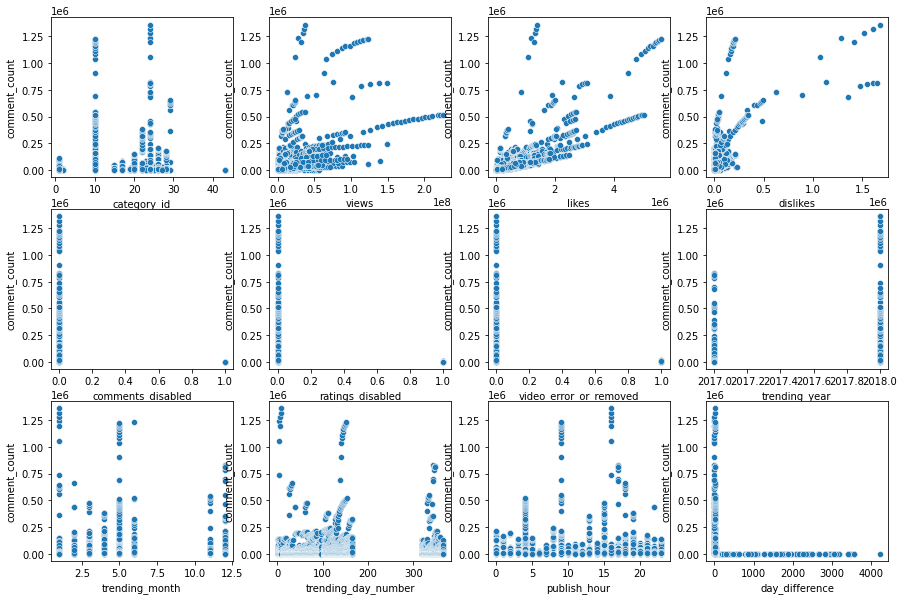

In [ ]:
fig,ax = plt.subplots(3, 4, figsize = (15,10))
for var,subplot in zip(features,ax.flatten()):
  sns.scatterplot(x=var, y=target, data=data_x, ax=subplot)

## Model 1: Simple Regression

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
dev_X, test_X, dev_y, test_y = train_test_split(data_x, target, test_size = 0.2, random_state=42)
preprocess = make_column_transformer((StandardScaler(), features))

In [ ]:
pipe1 = make_pipeline(preprocess, LinearRegression())
scores = cross_val_score(pipe1, dev_X, dev_y, cv = 10, error_score='raise')
print(scores)
print(np.mean(scores))


[0.84143397 0.79162735 0.85110526 0.80806823 0.84360624 0.79114055
 0.84856552 0.83974402 0.81173306 0.79690653]
0.8223930722042333


## Model 2: Ridge Regression

### Simple Model:

In [ ]:
from sklearn.linear_model import Ridge
pipe2 = make_pipeline(preprocess, Ridge())
scores2 = cross_val_score(pipe2, dev_X, dev_y, cv = 10, error_score='raise')
print(scores2)
print(np.mean(scores2))

[0.84142237 0.79164155 0.85109682 0.80807644 0.84361196 0.79115193
 0.84856785 0.83973098 0.81176345 0.79689515]
0.8223958492022951


### Hyperparameter Tuning

In [ ]:
pipe2_tuning = make_pipeline(preprocess, GridSearchCV(Ridge(), param_grid = [{"alpha":np.logspace(-3,3,30)}],return_train_score=True))
pipe2_tuning.fit(dev_X, dev_y)
grid_search_results2 = pipe2_tuning.named_steps["gridsearchcv"]
print(f"Best score:", grid_search_results2.best_score_)
print(f"Best alpha:", grid_search_results2.best_params_)
print(f"Test score:", pipe2_tuning.score(test_X, test_y))

Best score: 0.8273770526545304
Best alpha: {'alpha': 57.361525104486816}
Test score: 0.8315714133555114


## Model 3: Lasso Regression 

In [ ]:
from sklearn.linear_model import Lasso
pipe3 = make_pipeline(preprocess, Lasso(alpha=1))
scores3 = cross_val_score(pipe3, dev_X, dev_y, cv = 10, error_score='raise')
print(scores3)
print(np.mean(scores3))

[0.84140502 0.7916454  0.85109231 0.80807399 0.84362296 0.79116548
 0.84856794 0.83972784 0.81177676 0.7968878 ]
0.8223965490032896


### Hyperparameter Tuning

In [ ]:
pipe3_tuning = make_pipeline(preprocess, GridSearchCV(Lasso(), param_grid = [{"alpha":np.logspace(-4,2,30)}], return_train_score=True))
pipe3_tuning.fit(dev_X, dev_y)
grid_search_results3 = pipe3_tuning.named_steps["gridsearchcv"]
print(f"Best score:", grid_search_results3.best_score_)
print(f"Best alpha:", grid_search_results3.best_params_)
print(f"Test score:", pipe3_tuning.score(test_X, test_y))

Best score: 0.8273544467326704
Best alpha: {'alpha': 14.873521072935118}
Test score: 0.8314542049217191


## Model 4: Elastic-net Regression

In [ ]:
from sklearn.linear_model import ElasticNet
pipe4 = make_pipeline(preprocess, ElasticNet(alpha=1))
scores4 = cross_val_score(pipe4, dev_X, dev_y, cv = 10, error_score='raise')
print(scores4)
print(np.mean(scores4))

[0.69646994 0.82180525 0.70131963 0.69393446 0.72039836 0.73567716
 0.77512799 0.6815097  0.78225544 0.65242208]
0.7260920002825928


### Hyperparameter Tuning

In [ ]:
pipe4_tuning = make_pipeline(preprocess, GridSearchCV(ElasticNet(), param_grid = [{"alpha":np.logspace(-4,2,20),"l1_ratio":np.logspace(-2,0,10)}], return_train_score=True))
pipe4_tuning.fit(dev_X, dev_y)
grid_search_results4 = pipe4_tuning.named_steps["gridsearchcv"]
print(f"Best score:", grid_search_results4.best_score_)
print(f"Best alpha:", grid_search_results4.best_params_)
print(f"Test score:", pipe4_tuning.score(test_X, test_y))

Best score: 0.827377270906517
Best alpha: {'alpha': 0.0018329807108324356, 'l1_ratio': 0.01}
Test score: 0.8315807852813439


## Conclusion: 
Model 2 Ridge is the most accurate and efficient model to predict the number of comments

In [ ]:
pipe2_tuning.fit(dev_X, dev_y)
predicted_y = pipe2_tuning.predict(test_X)

Text(0, 0.5, 'residual')

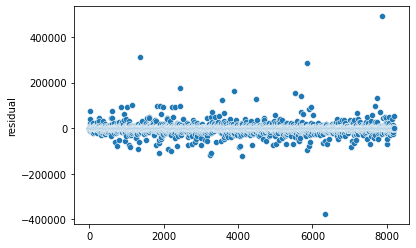

In [ ]:
ax = sns.scatterplot(np.arange(len(test_y)), (test_y - pipe2_tuning.predict(test_X)))
ax.set_ylabel("residual")

In [ ]:
print("Predicted Number of Comments:", predicted_y[:5],'\n', "Actual Number of Comments:", test_y[:5].to_list())

Predicted Number of Comments: [ 848.03820921 2131.15320138 4070.64985982 2336.97707021 1338.28882784] 
 Actual Number of Comments: [2951, 2142, 2233, 2000, 1038]
